# 用OpenCV辨认颜色

物体的区域特征划分可以通过颜色直方图和基本颜色统计（例如中位数或均方差）来完成。

在程序进行分组或者统计时，即使区域内实际上是用颜色作为特征，例如，"红色","绿色","蓝色"，但程序却不懂为分组起个有意义的名字。

本文就是要利用Lab 色彩空间配合Eudlidean距离，用Python和OpenCV来为不同的区块做标记。

In [25]:
class ShapeDetector:
    def __init__(self):
        pass
    
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
        
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        
        # return the name of the shape
        return shape

In [26]:
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
import cv2
 
class ColorLabeler:
    def __init__(self):
        # initialize the colors dictionary, containing the color
        # name as the key and the RGB tuple as the value
        colors = OrderedDict({
            "red": (255, 0, 0),
            "green": (0, 255, 0),
            "blue": (0, 0, 255)})

        # allocate memory for the L*a*b* image, then initialize
        # the color names list
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []

        # loop over the colors dictionary
        for (i, (name, rgb)) in enumerate(colors.items()):
            # update the L*a*b* array and the color names list
            self.lab[i] = rgb
            self.colorNames.append(name)

        # convert the L*a*b* array from the RGB color space
        # to L*a*b*
        self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)
        
    def label(self, image, c):
        # construct a mask for the contour, then compute the
        # average L*a*b* value for the masked region
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        mask = cv2.erode(mask, None, iterations=2)
        mean = cv2.mean(image, mask=mask)[:3]

        # initialize the minimum distance found thus far
        minDist = (np.inf, None)

        # loop over the known L*a*b* color values
        for (i, row) in enumerate(self.lab):
            # compute the distance between the current L*a*b*
            # color value and the mean of the image
            d = dist.euclidean(row[0], mean)

            # if the distance is smaller than the current distance,
            # then update the bookkeeping variable
            if d < minDist[0]:
                minDist = (d, i)

        # return the name of the color with the smallest distance
        return self.colorNames[minDist[1]]

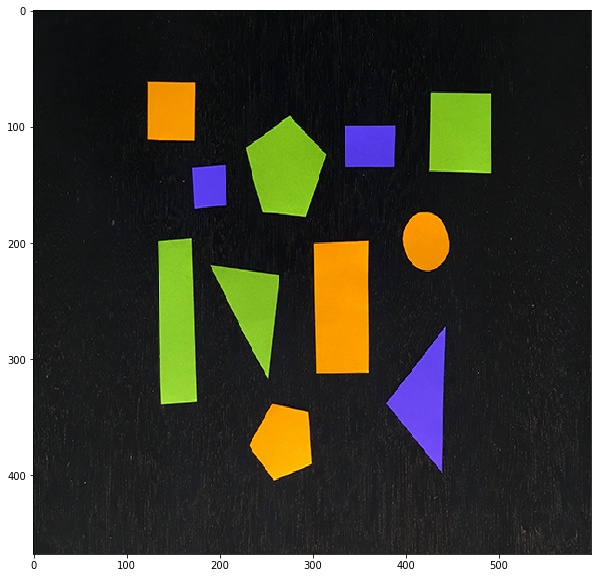

In [27]:
# import the necessary packages
import matplotlib.pyplot as plt
import imutils
import cv2

# load the image and resize it to a smaller factor so that
# the shapes can be approximated better
image = cv2.imread("example_shapes.png")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB);
plt.figure(figsize = (10,10))
plt.imshow(image, interpolation='nearest', aspect='auto')

Ratio=1.5


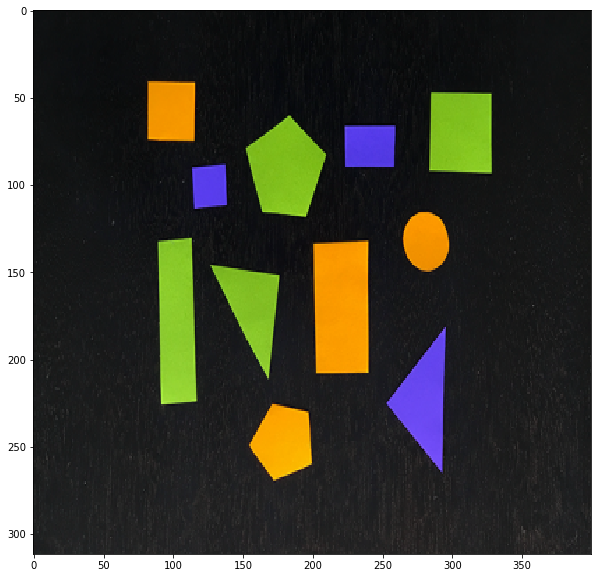

In [28]:
resized = imutils.resize(image, width=400)
ratio = cloned_image.shape[0] / float(resized.shape[0])

print("Ratio={}".format(ratio))

plt.figure(figsize = (10,10))
plt.imshow(resized, interpolation='nearest', aspect='auto')

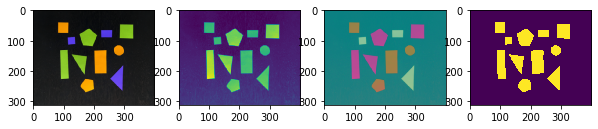

In [29]:
# blur the resized image slightly, then convert it to both
# grayscale and the L*a*b* color spaces
blurred = cv2.GaussianBlur(resized, (5, 5), 0)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]

images = [blurred, gray, lab, thresh]
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
plt.show()

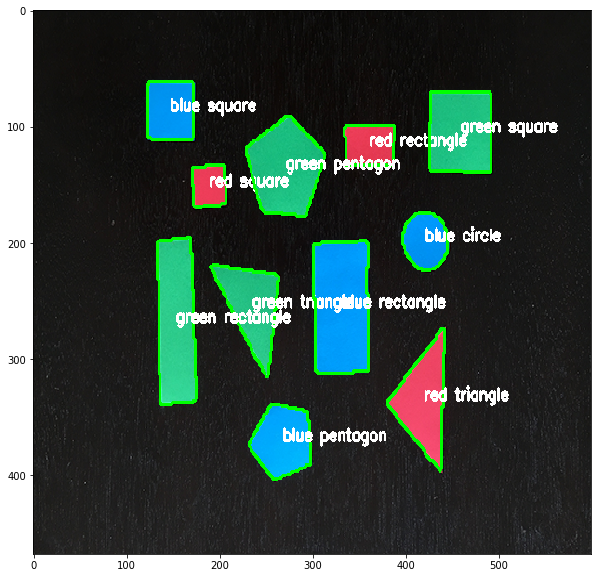

In [30]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# initialize the shape detector and color labeler
sd = ShapeDetector()
cl = ColorLabeler()

# loop over the contours
for c in cnts:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)

    # detect the shape of the contour and label the color
    shape = sd.detect(c)
    color = cl.label(lab, c)

    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape and labeled
    # color on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    text = "{} {}".format(color, shape)
    cv2.drawContours(rgb_image, [c], -1, (0, 255, 0), 2)
    cv2.putText(rgb_image, text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# show the output image
plt.figure(figsize = (10,10))
plt.imshow(rgb_image, interpolation='nearest', aspect='auto')